In [1]:
# Instalar biblioteca watermark para visualização de ambiente e versões de pacotes foram usados no projeto
#%pip install -q -U watermark

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Instala a biblioteca missingno para visualização de dados ausentes.
#%pip install -q -U missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Instala a biblioteca pyampute para simular a ausência de dados.
#%pip install -q -U pyampute

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importar bibliotecas
from datetime import datetime

import pandas as pd
import numpy as np

pd.set_option('future.no_silent_downcasting', True)

# **Tratamento de Ausentes/Inconsistências**

* Identifique valores ausentes, imputação e inconsistências; elimine duplicatas ou erros evidentes.




In [5]:
# Carregar base de dados
df=pd.read_csv("heart_disease_uci.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


## **Tipos de Dados Ausentes**

* OBS: A identificação do padrão dos dados ausentes influenciará a estratégia de tratamento



In [7]:
# Importar bibliotecas
import missingno as msno
import matplotlib.pyplot as plt

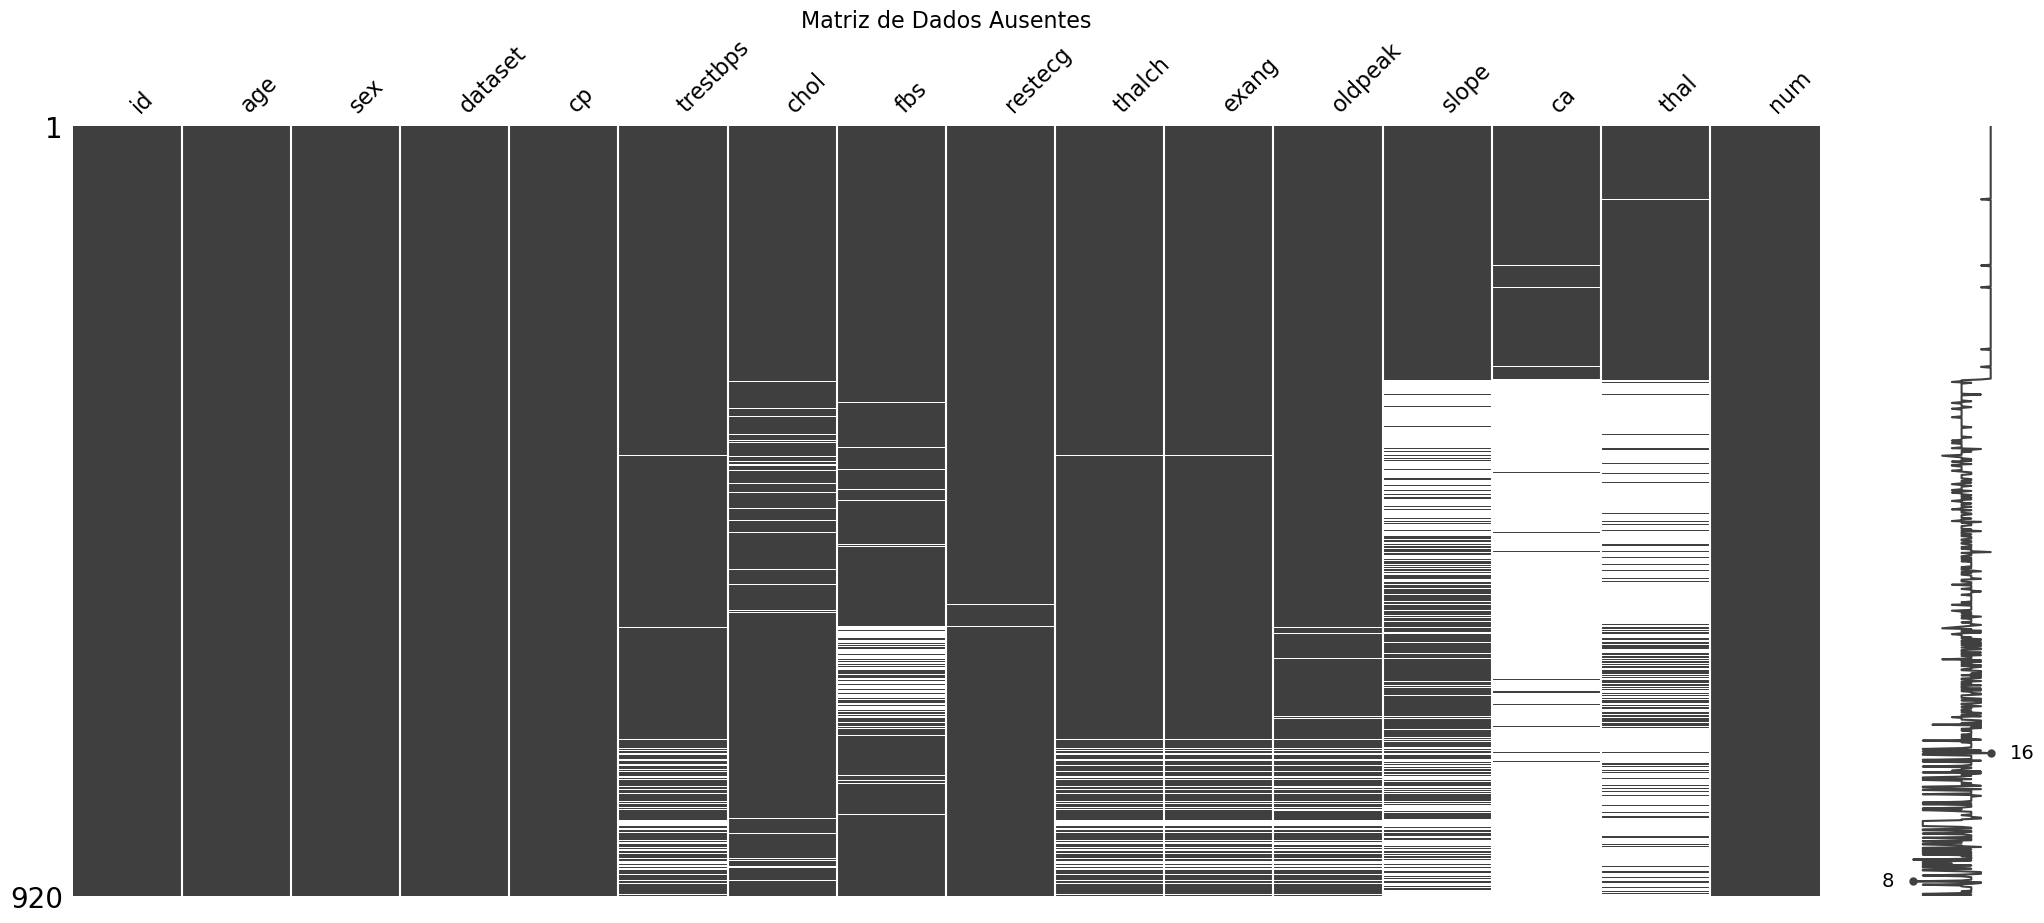

In [8]:
# Matriz de Nulos
# Mostra onde estão os dados ausentes. Padrões horizontais podem indicar que um paciente específico
# tem muitos dados faltando. Padrões verticais indicam colunas problemáticas.
msno.matrix(df)
plt.title('Matriz de Dados Ausentes', fontsize=16)
plt.show()

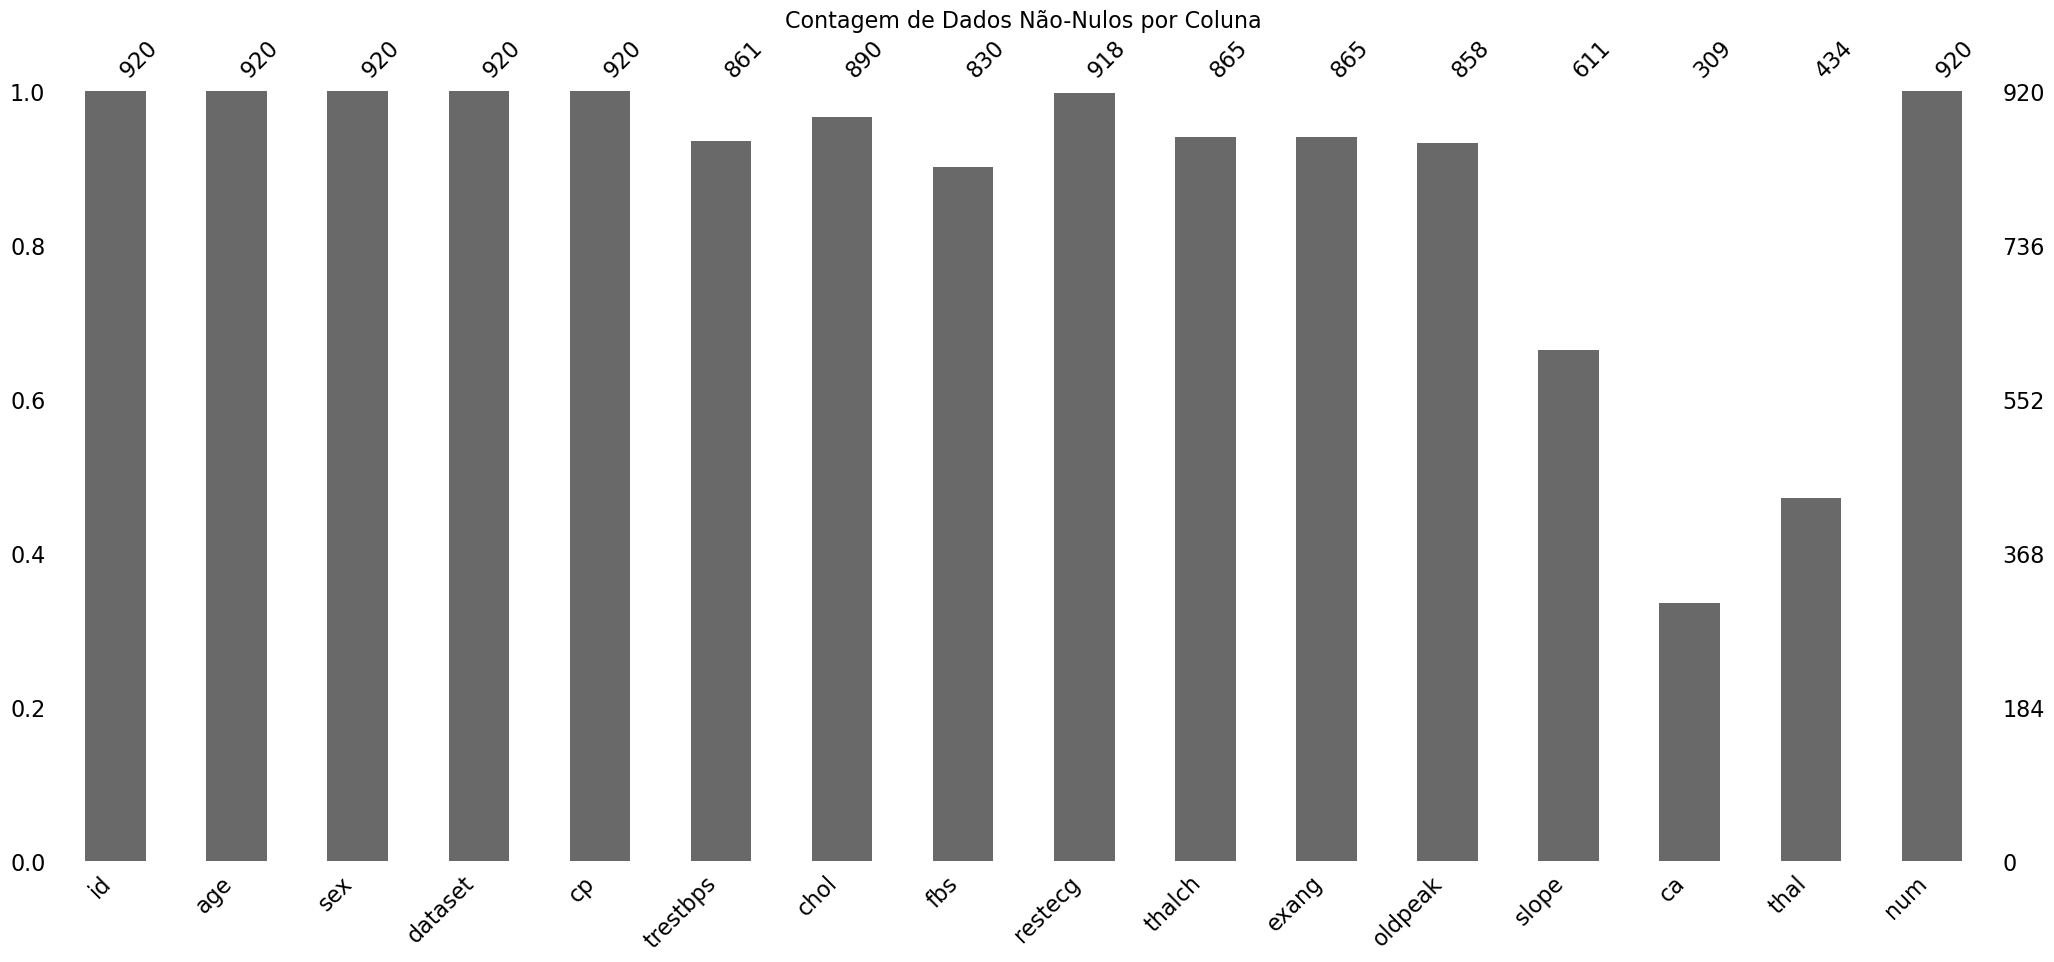

In [9]:
# Gráfico de Barras
# Simplesmente conta a quantidade de dados não-nulos por coluna.
msno.bar(df)
plt.title('Contagem de Dados Não-Nulos por Coluna', fontsize=16)
plt.show()

### **Pipeline automático de análise de padrão de dados ausentes**

Ele vai percorrer **todas as colunas com nulos** e, para cada uma:

1. Criar a variável indicadora de ausência.
2. Testar associação com **variáveis numéricas** usando **t-test**.
3. Testar associação com **variáveis categóricas** usando **qui-quadrado**.
4. Retornar um **resumo indicando se o padrão é provavelmente MCAR ou MAR**.

* **MCAR (Missing Completely at Random - Completamente Aleatório)**: A ausência de um dado não tem NENHUMA relação com qualquer outra variável do dataset, nem com o valor que estaria ali.

* **MAR (Missing at Random - Aleatório, mas com Padrão)**: A ausência de um dado PODE ser explicada por OUTRAS variáveis no seu dataset.

In [10]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Variáveis de referência para testes
num_vars = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
cat_vars = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# --- CONFIGURAÇÃO ---
MIN_SAMPLE_SIZE = 5  # Define um tamanho mínimo para a amostra ser considerada válida

# --- INICIALIZAÇÃO ---
# Lista de colunas com dados ausentes
cols_with_missing = df.columns[df.isnull().any()]

# Listas para armazenar os resultados e os avisos
results = []
skipped_tests = [] # NOVA LISTA PARA ARMAZENAR MENSAGENS DE TESTES PULADOS

# --- LÓGICA PRINCIPAL ---
for col in cols_with_missing:
    # Criar coluna indicadora de ausência
    df[f"{col}_is_missing"] = df[col].isnull()
    col_result = {'column': col, 'MAR_num': False, 'MAR_cat': False, 'likely_pattern': 'MCAR'}

    # --- Teste para variáveis numéricas ---
    for num in num_vars:
        if num == col:
            continue

        grupo_com = df[df[f"{col}_is_missing"] == False][num]
        grupo_sem = df[df[f"{col}_is_missing"] == True][num]
        
        size_com = grupo_com.dropna().shape[0]
        size_sem = grupo_sem.dropna().shape[0]
        
        # VERIFICAÇÃO: Se ambos os grupos têm o tamanho mínimo
        if size_com >= MIN_SAMPLE_SIZE and size_sem >= MIN_SAMPLE_SIZE:
            ttest = ttest_ind(grupo_com, grupo_sem, nan_policy='omit')
            if not pd.isna(ttest.pvalue) and ttest.pvalue < 0.05:
                col_result['MAR_num'] = True
        # SE A CONDIÇÃO NÃO FOR ATENDIDA, REGISTRE O AVISO
        else:
            msg = f"- Teste T para '{col}' vs '{num}': Não realizado (Amostras: Presente={size_com}, Ausente={size_sem})"
            skipped_tests.append(msg)

    # --- Teste para variáveis categóricas ---
    for cat in cat_vars:
        if cat == col:
            continue
        
        # Para o teste qui-quadrado, verificamos o tamanho total dos grupos
        group_counts = df[f"{col}_is_missing"].value_counts()
        size_com_cat = group_counts.get(False, 0)
        size_sem_cat = group_counts.get(True, 0)
        
        # VERIFICAÇÃO: Se ambos os grupos têm o tamanho mínimo
        if size_com_cat >= MIN_SAMPLE_SIZE and size_sem_cat >= MIN_SAMPLE_SIZE:
            contingency_table = pd.crosstab(df[cat], df[f"{col}_is_missing"])
            
            # Checagem adicional para o qui-quadrado (evitar tabelas vazias)
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                chi2_result = chi2_contingency(contingency_table)
                if chi2_result[1] < 0.05:
                    col_result['MAR_cat'] = True
            else:
                msg = f"- Teste Qui-Quadrado para '{col}' vs '{cat}': Não realizado (Tabela de contingência inválida)"
                skipped_tests.append(msg)
        # SE A CONDIÇÃO NÃO FOR ATENDIDA, REGISTRE O AVISO
        else:
            msg = f"- Teste Qui-Quadrado para '{col}' vs '{cat}': Não realizado (Amostras: Presente={size_com_cat}, Ausente={size_sem_cat})"
            skipped_tests.append(msg)


    # --- Determinar padrão provável ---
    if col_result['MAR_num'] or col_result['MAR_cat']:
        col_result['likely_pattern'] = 'MAR'
    results.append(col_result)

# --- SAÍDA FINAL ---
# Imprimir os avisos de testes não realizados, se houver algum
if skipped_tests:
    # Remove duplicados
    unique_skipped = sorted(list(set(skipped_tests)))
    print("--- Relatório de Correlações Não Realizadas (Amostra Pequena) ---")
    for msg in unique_skipped:
        print(msg)
    print("-" * 60)

# Criar e imprimir o DataFrame resumo
df_missing_pattern = pd.DataFrame(results)
print("\n--- Resultado da Análise de Padrão de Ausência ---")
print(df_missing_pattern)

--- Relatório de Correlações Não Realizadas (Amostra Pequena) ---
- Teste Qui-Quadrado para 'oldpeak' vs 'slope': Não realizado (Tabela de contingência inválida)
- Teste Qui-Quadrado para 'restecg' vs 'cp': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'dataset': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'exang': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'fbs': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'sex': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'slope': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'restecg' vs 'thal': Não realizado (Amostras: Presente=918, Ausente=2)
- Teste Qui-Quadrado para 'thalch' vs 'exang': Não realizado (Tabela de contingência inválida)
- Teste T para 'chol' vs 'ca': Não realizado (Amostras: Present

In [11]:
# Verificando colunas de agrupamentos criadas
colunas = df.columns.tolist()
print("Nomes das colunas:", colunas)

Nomes das colunas: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'trestbps_is_missing', 'chol_is_missing', 'fbs_is_missing', 'restecg_is_missing', 'thalch_is_missing', 'exang_is_missing', 'oldpeak_is_missing', 'slope_is_missing', 'ca_is_missing', 'thal_is_missing']


In [12]:
# Removendo colunas de agrupamentos criadas para os testes
df.drop(columns=['trestbps_is_missing', 'chol_is_missing', 'fbs_is_missing', 'restecg_is_missing', 'thalch_is_missing',
                 'exang_is_missing', 'oldpeak_is_missing', 'slope_is_missing', 'ca_is_missing', 'thal_is_missing'], inplace=True)

**INTERPRETAÇÃO DOS RESULTADOS**
* As **variáveis** cujo o resultado foi **MAR** a ausência de um dado não é um evento totalmente aleatório e sem sentido. Pelo contrário,
está sistematicamente relacionada a outras variáveis do dataset. O fato de um valor estar faltando é, por si só, uma informação.
* As **variáveis** cujo o resultado foi **MCAR** a ausência de dados parece ser verdadeiramente aleatória,
como se alguém tivesse esquecido de preencher o campo por acaso, sem qualquer relação com as outras características do paciente

**POSSÍVEIS SOLUÇÕES**

1. **Abordagem Avançada**:
  
* Para as **variáveis** cujo o resultado foi **MAR**:
   * **Usar método de Imputação Múltipla (MICE)**, considerado o padrão ouro para dados MAR para cria várias versões completas do dataset com preenchimentos plausíveis e combina os resultados.
   * **Usar método de Imputação Baseada em Modelos**, por exemplo, um algoritmos de Machine Learning para prever os valores ausentes, como:  **KNNImputer** (que usa os "vizinhos" mais próximos para preencher) ou um modelo de **Regressão/Classificação**.
     
* Para a **variável** cujo o resultado foi **MCAR**:
  * **Deleção de Linhas**: Se a quantidade de valores ausentes for muito pequena (ex: < 5% do total de linhas), simplesmente deletar essas poucas linhas.
  * **Imputação Simples**: Preencher com a moda.
    
2. **Abordagem Simples**:
   
* As colunas **Numéricas contínuas** com **< 10%** de dados ausentes **preencher** com a **mediana**.
* As colunas **Categóricas** com **< 10%** de dados ausentes **preencher** com a **moda**.
* As colunas **Numéricas ou Categóricas** com **> 30%** de dados ausentes **deletar**.

In [13]:
# Imprimir o percentual de valores ausentes (nulos) de cada coluna
print(round(df.isnull().sum() * 100 / len(df), 2).astype(str) + '%')

id            0.0%
age           0.0%
sex           0.0%
dataset       0.0%
cp            0.0%
trestbps     6.41%
chol         3.26%
fbs          9.78%
restecg      0.22%
thalch       5.98%
exang        5.98%
oldpeak      6.74%
slope       33.59%
ca          66.41%
thal        52.83%
num           0.0%
dtype: object


### **Decisão**
* **Não haverá deleção de linhas**, pois diminuiria o tamanho da amostra
* As colunas **'ca'** e **'thal'** serão **deletada** integralmente, pois possuem mais de 50% de dados ausentes.
* As colunas **'trestbps', 'chol', 'thalch', 'oldpeak', 'fbs', 'restecg', 'exang'** passaram por imputação de dados pela **abordagem simples**
* A coluna **'slope'** passaram por imputação de dados pela **abordagem avançada - KNNImputer**

In [14]:
# Remover colunas 'ca' e 'thal'.
df.drop(columns=['ca', 'thal'], inplace=True)

## **Imputação de dados - Abordagem Simples**

In [15]:
# Lista de colunas numéricas contínuas com < 10% de dados ausentes
colunas_numericas = ['trestbps', 'chol', 'thalch', 'oldpeak']

# Preencher com a mediana
for col in colunas_numericas:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)

In [16]:
# Lista de colunas categóricas com < 10% de dados ausentes
colunas_categoricas = ['fbs', 'restecg', 'exang']

# Preencher com a moda
for col in colunas_categoricas:
    # Usamos .mode()[0] porque a moda pode retornar mais de um valor se houver empate
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda).infer_objects(copy=False)

## **Imputação de dados - Abordagem Avançada**

In [17]:
df['slope'].value_counts()

slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64

In [18]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#  PRÉ-CODIFICAR A COLUNA ALVO 'slope' ---
# Criamos um dicionário para mapear os textos para números
mapeamento_slope = {
    'upsloping': 1,
    'flat': 2,
    'downsloping': 3
}
df['slope'] = df['slope'].map(mapeamento_slope)

# Inicializar df_final como uma cópia de df
df_final = df.copy()

# SEPARAR O ALVO (y) DOS PREDITORES (X) ---
X = df.drop(columns=['slope'])
y = df[['slope']]

# PRÉ-PROCESSAMENTO DE X ---
colunas_categoricas = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang']
X_encoded = pd.get_dummies(X, columns=colunas_categoricas, dummy_na=False)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# COMBINAR E APLICAR O KNNIMPUTER ---
combined_data = np.hstack([X_scaled, y.values])
k = 3
imputer = KNNImputer(n_neighbors=k)
data_imputed = imputer.fit_transform(combined_data)

# EXTRAIR E ATUALIZAR A COLUNA 'slope' ---
imputed_slope_values = data_imputed[:, -1]
imputed_slope_rounded = np.round(imputed_slope_values)
df_final['slope'] = imputed_slope_rounded

# REVERTER A COLUNA PARA TEXTO ---

# Primeiro, criamos o mapeamento reverso automaticamente a partir do original
mapeamento_reverso_slope = {valor: chave for chave, valor in mapeamento_slope.items()}
# O resultado será: {1: 'upsloping', 2: 'flat', 3: 'downsloping'}
print("Mapeamento reverso criado:", mapeamento_reverso_slope)

# Aplicamos o mapeamento reverso à nossa coluna 'slope' já imputada e arredondada
df_final['slope'] = df_final['slope'].map(mapeamento_reverso_slope)

# --- VERIFICAÇÃO FINAL ---
print("\n--- DataFrame Final com 'slope' Imputado e Revertido para Texto ---")
print(df_final.head())
print("\nValores únicos na coluna 'slope' após todo o processo:")
print(df_final['slope'].unique())

Mapeamento reverso criado: {1: 'upsloping', 2: 'flat', 3: 'downsloping'}

--- DataFrame Final com 'slope' Imputado e Revertido para Texto ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope  num  
0  lv hypertrophy   150.0  False      2.3  downsloping    0  
1  lv hypertrophy   108.0   True      1.5         flat    2  
2  lv hypertrophy   129.0   True      2.6         flat    1  
3          normal   187.0  False      3.5  downsloping    0  
4  lv hypertrophy   172.0  False      1.4    upsloping    0  

Valores únicos na coluna 'slope' após to

In [19]:
df['slope'].value_counts()

slope
2.0    345
1.0    203
3.0     63
Name: count, dtype: int64

In [20]:
df_final['slope'].value_counts()

slope
flat           575
upsloping      274
downsloping     71
Name: count, dtype: int64

In [21]:
# Imprimir o percentual de valores ausentes (nulos) de cada coluna
print(round(df_final.isnull().sum() * 100 / len(df), 2).astype(str) + '%')

id          0.0%
age         0.0%
sex         0.0%
dataset     0.0%
cp          0.0%
trestbps    0.0%
chol        0.0%
fbs         0.0%
restecg     0.0%
thalch      0.0%
exang       0.0%
oldpeak     0.0%
slope       0.0%
num         0.0%
dtype: object


## **Verificar Duplicatas**

In [22]:
# Verificar o número total de linhas duplicadas
df_final.duplicated().sum()

np.int64(0)

In [23]:
# Verificar informações da base de dados - nome das colunas, total de registro por coluna e tipo que o dado foi armazenado
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    bool   
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    bool   
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  num       920 non-null    int64  
dtypes: bool(2), float64(4), int64(3), object(5)
memory usage: 88.2+ KB


### **Salvar dataset tratado**

In [24]:
# Definir o nome do arquivo de saída
nome_do_arquivo = 'heart_disease_uci_tratado_1.csv'

# Salvar o DataFrame em CSV, sem o índice e com codificação UTF-8
df_final.to_csv(nome_do_arquivo, index=False, encoding='utf-8')

# 3. Imprimir uma mensagem de confirmação
print(f"DataFrame foi salvo com sucesso no arquivo: '{nome_do_arquivo}'")

DataFrame foi salvo com sucesso no arquivo: 'heart_disease_uci_tratado_1.csv'


In [25]:
# Carregando a extensão watermark
%reload_ext watermark

In [26]:
# Imprimir
# -a (autor do projeto)
# -v (versões do Python e do IPython)
# -m (informações sobre a máquina (hardware e sistema operacional))
# --iversions (versões de pacotes importadas (import))
agora = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
%watermark -a "Patrick F. R. Ribeiro" -v -m --iversions
print(f"Última atualização: {agora}")

Author: Patrick F. R. Ribeiro

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 8.30.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

sklearn   : 1.6.1
matplotlib: 3.10.0
scipy     : 1.15.3
numpy     : 2.3.1
missingno : 0.5.2
pandas    : 2.2.3

Última atualização: 2025-09-19 08:07:25
